# Predicting Presidential Elections based on Name Popularity

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import glob
import os
from pathlib import Path
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.model_selection import train_test_split #for decision tree object
from sklearn.tree import DecisionTreeClassifier #for checking testing results
from sklearn.metrics import classification_report, confusion_matrix #for visualizing tree 
from sklearn.tree import plot_tree
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict

## Web Scraping Presidential Candidate Data

In [2]:
# BeautifulSoup code sources used to learn

# https://realpython.com/beautiful-soup-web-scraper-python/#inspect-the-site-using-developer-tools
# https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e

In [3]:
URL = 'https://en.wikipedia.org/wiki/United_States_presidential_election'
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

In [4]:
table = soup.find('table', class_='wikitable sortable')

In [5]:
# This code cell deals with the situation where a value spans multiple rows, which ordinarily would just be read as one value and would throw off the table.
# This code cell was adapted from:
# https://stackoverflow.com/questions/35098857/how-to-handle-rowspan-while-scraping-a-wikitable-using-python

rows = table.findAll("tr") # finds each table row

for i in range(len(rows)):
    rows[i]=rows[i].findAll(['th', 'td']) # makes a list for each row containing each header and data cell

for i in range(len(rows)): # iterate through the rows
    row = rows[i] # take a single row out
    for j in range(len(row)): # grab each column from that row list
        col = row[j] 
        del col['style']
        if (col.get('rowspan')): # if the column spans multiple rows
            rSpanLen = int(col.get('rowspan')) # find how many rows it spans
            del col['rowspan'] 
            for k in range(1, rSpanLen):
                rows[i+k].insert(j,col) # repeat the element however many rows it spans


In [6]:
# initialize an empty dataframe
df = pd.DataFrame(columns=['Year', 'Party', 'Presidential Candidate','Presidential Candidate Wiki Link','Vice Presidential Candidate', 
                           'Popular Vote', '% of Popular Vote', 'Electoral Votes', 'Notes'])
# this section goes through each row in the table and adds appends it to the dataframe
for row in rows[1:]:
    year = row[0].text.strip()
    party = row[1].text.strip()
    candidate = row[2].text.strip()
    candidate_ref = row[2].find_all('a', href=True)[0]['href']
    vp_candidate = row[3].text.strip()
    popular = row[4].text.strip()
    perc = row[5].text.strip()
    electoral = row[6].text.strip()
    notes = row[7].text.strip()
    df = df.append({'Year': year, 'Party': party, 'Presidential Candidate': candidate, 'Presidential Candidate Wiki Link': candidate_ref,
                    'Vice Presidential Candidate': vp_candidate,'Popular Vote': popular, '% of Popular Vote': perc, 
                    'Electoral Votes': electoral, 'Notes': notes}, 
                   ignore_index = True)
    

In [7]:
df_1930 = df[df.Year > '1930'] # Subset the data to elections after 1930 

In [8]:
def scrape_profile(end_link, term_year=None, spouse_child = False):
    '''This function of code scrapes an individuals wikipedia page to get needed information.'''
    num_output_params = 1 + spouse_child*6 # get the number of parameters to set the length of output
    output = ['N/A'] * num_output_params # set a blank input, so if any variables aren't found, they remain N/A
    full_link = 'https://en.wikipedia.org' + end_link # create the entire wikipedia link
    page = requests.get(full_link) # load in the page
    soup = BeautifulSoup(page.content, "html.parser") # pull all the html from the page
    table = soup.find('table', class_='infobox vcard') # find the biography table
    if table == None: # if its not found
        table = soup.find('table', class_='infobox biography vcard') # try this other searc
    if table == None: # if its still not found
        return output # exit the function
    rows = table.find_all(['th','td']) # pull all rows of text from the table
    for i, row in enumerate(rows):
        # this section pulls the birthday for each candidate
        if row.text == 'Born': # if the row is 'Born'
            date_text = rows[i+1].find_all('span') # pull the date from the following row
            if date_text == []: # if date isn't found, leave it as N/A
                continue
            else:
                date = re.findall('\d{4}\-\d{1,2}\-\d{1,2}', date_text[0].text) # use a regular expression to get just the date and ensure its a date
                if date == []: # if date isn't found, leave it as N/A
                    continue
                else: # otherwise return the date
                    output[0] = date[0] 
                
        # this section pulls the spouse for each candidate during their term and the link to the spouses wikipedia page
        elif (row.text == 'Spouse(s)') & (spouse_child == True): 
            allspouses = rows[i+1].text.replace('\u200b', '').replace('\xa0', '').replace('\n', '') # pull the spouse text and remove non-relevant characters
            num_spouses = len(allspouses.split(')')) - 1 # count the number of spouses
            for idx,j in enumerate(allspouses.split(')')[-1::-1]): # go through the spouses in reverse order
                married_year = re.findall('m.(\d{4})', j) # pull the married year from the spouse
                if married_year == []: # if it's empty, go with the first spouse found
                    spouse_number = 1
                    continue
                elif married_year[0] <= term_year: # the first time the married year is before the term year, take that spouse number
                    spouse_number = len(allspouses.split(')')[-1::-1]) - idx
                    break
            output[1] = num_spouses # output the number of spouses
            spouse_first_name = re.findall('\s?(\w+)(?:$|\s|,)', allspouses.split(')')[spouse_number-1])[0] # pull the spouses first name
            output[2] = spouse_first_name # output it
            spouse_links = rows[i+1].find_all('a', href=True) # get the links for all spouses
            if spouse_links == []: # if it's empty move on
                continue
            elif spouse_number > len(spouse_links): # if there are fewer links than spouses, assume the one linked is the most famous and most likely the one married to during term 
                output[3] = rows[i+1].find_all('a', href=True)[0]['href']
            else: # else select the one corresponding to spouse_number
                output[3] = rows[i+1].find_all('a', href=True)[spouse_number - 1]['href']
        elif (row.text == 'Children') & (spouse_child == True):
            child_text = rows[i+1].text.strip('\n').replace('\xa0', ' ').replace('\n', ', ') # pull all the child text and remove non-relevant characters
            num_children = re.findall('\d+', child_text) # if there is a digit in the child portion, take that as the number of children
            if num_children == []: # if no digit is found
                child_split = child_text.split(',') # split the text on the commas
                output[4] = len(child_split) # and count how many there are
            else:
                output[4] = num_children[0] # otherwise use the number found previously
            child_text_stripped = re.sub('\d, including', '', child_text) # remove the leading digit and text from the string
            first_child = re.findall('\s?([A-Z][a-z]+)(?:$|\s|,|[A-Z])', child_text_stripped) # find the first listed child's first name
            if (first_child == None) or (first_child == []): # if nothing is found
                output[5] = 'N/A' # output N/A
            else:
                output[5] = first_child[0] # otherwise, output the child
            children_links = rows[i+1].find_all('a', href=True) # pull the links for all children
            if children_links == []: # if none are found, leave it as N/A and continue
                continue
            else: # if one is found
                test_link = rows[i+1].find_all('a', href=True)[0]['href'] # take the link
                test_link_match = re.findall('/wiki/.*', test_link) # ensure it's the right format
                if test_link_match == []: # if it's not, leave it as N/A
                    continue
                else:
                    output[6] = test_link # otherwise output it   
        
        
    return output


In [9]:
# For each candidate in the table, scrape their pages, and create a list of lists with the output
info = []
for candidate in range(len(df_1930)):
    if df_1930['Presidential Candidate Wiki Link'].iloc[candidate] == '/wiki/Faith_Spotted_Eagle': 
        info += [['N/A'] * 5]
        continue
    info += [scrape_profile(df_1930['Presidential Candidate Wiki Link'].iloc[candidate], term_year = df_1930['Year'].iloc[candidate], spouse_child = True)]

In [10]:
# create a dataframe from the page information
df_addition = pd.DataFrame(info, columns = ['Candidate Birthday', 'Number of Spouses', 'Candidate Spouse', 'Spouse Link', 'Number of Children', 'First Child', 'First Child Link'])

In [11]:
# for each candidate, scrape their spouses and childs pages to get their birthdays, skip any that don't have links
spouse_info = []
for spouse in range(len(df_addition)):
    if df_addition['Spouse Link'].iloc[spouse] == 'N/A': 
        spouse_info += ['N/A']
        continue
    spouse_info += scrape_profile(df_addition['Spouse Link'].iloc[spouse])

child_info = []
for child in range(len(df_addition)):
    if (df_addition['First Child Link'].iloc[child] == 'N/A') or (df_addition['First Child Link'].iloc[child] == None): 
        child_info += ['N/A']
        continue
    child_info += scrape_profile(df_addition['First Child Link'].iloc[child])


In [12]:
# add spouse and child information to addition dataframe
df_addition['Spouse Birthday'] = spouse_info
df_addition['Child Birthday'] = child_info

In [13]:
# concate
df_unclean = pd.concat([df_1930.reset_index().drop('index', axis=1), df_addition], axis=1)

In [14]:
# initialize empty lists for electoral percentage and election outcome
electoral_percentage = []
outcome = []
for entry in df_unclean['Electoral Votes']: # go through the electoral votes column
    num_list = entry.split('/') # split into numerator and denominator
    percentage = float(num_list[0]) / float(num_list[1]) # convert both to float and divide to get percent
    electoral_percentage += [percentage] # add that to list
    if percentage > 0.50: # if percent is above 0.5
        outcome += [1] # they won the election
    else:
        outcome += [0] # otherwise, they lost
        
# add both of these to the dataframe
df_unclean['Electoral Percentage'] = electoral_percentage
df_unclean['Election Outcome'] = outcome

In [15]:
df_reduced = df_unclean[df_unclean['Electoral Percentage'] > 0.01].copy() # remove candidates with less than 1% of electoral votes
pop_vote_perc = [] # empty list for popular vote percentage
for entry in df_reduced['% of Popular Vote']: # go through the string
    pop_vote_perc += [float(entry.strip('%'))/100] # strip off the % and divide by 100 to get percent
    
df_reduced['% of Popular Vote'] = pop_vote_perc # add to reduced dataframe

In [16]:
# missing child name for George McGovern and Bob Dole -- found manual birthdays for them
# Dwight Eisenhower's child linked is not correct, change child name to John

# Manual corrections
df_reduced.loc[df_reduced['Presidential Candidate'] == 'George McGovern', 'First Child'] = "Ann"
df_reduced.loc[df_reduced['Presidential Candidate'] == 'George McGovern', 'Child Birthday'] = "1945-01-01"
df_reduced.loc[df_reduced['Presidential Candidate'] == 'Bob Dole', 'First Child'] = "Robin"
df_reduced.loc[df_reduced['Presidential Candidate'] == 'Bob Dole', 'Child Birthday'] = "1954-10-15"
df_reduced.loc[df_reduced['Presidential Candidate'] == 'Dwight D. Eisenhower', 'First Child'] = "John"
df_reduced.loc[df_reduced['Presidential Candidate'] == 'Herbert Hoover', 'Candidate Birthday'] = "1880-01-01" # changing his dob to the earliest year we have
df_reduced.loc[df_reduced['Presidential Candidate'] == 'Herbert Hoover', 'Spouse Birthday'] = "1880-01-01" # changing his dob to the earliest year we have

In [17]:
# have spouse name for everyone -- assume spouse was born the same year as candidate if birthday is N/A
# any child birthday N/A -- assume child has birthday 30 years after candidate birthday

# Coding Assumptions
df_reduced['Candidate Birthday'] = pd.to_datetime(df_reduced['Candidate Birthday'])

for i, entry in enumerate(df_reduced['Spouse Birthday']):
    if entry == "N/A":
        df_reduced['Spouse Birthday'].iloc[i] = df_reduced['Candidate Birthday'].iloc[i] # set spouse birthday equal to candidate

df_reduced['Candidate Birthday'] = pd.to_datetime(df_reduced['Candidate Birthday']) # convert candidate birthday to datetime

for i, entry in enumerate(df_reduced['Child Birthday']):
    if entry == "N/A":
        year = df_reduced['Candidate Birthday'].iloc[i].year + 30 # add thirty to candidate birth year
        df_reduced['Child Birthday'].iloc[i] = str(year) + '-01-01' # make a date string
    
# convert spouse and child birthdays to datetime
df_reduced['Spouse Birthday'] = pd.to_datetime(df_reduced['Spouse Birthday'])
df_reduced['Child Birthday'] = pd.to_datetime(df_reduced['Child Birthday'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
# use regex to pull just the candidate's first name
first_name = []
for entry in df_reduced['Presidential Candidate']:
    first_name += [re.findall('([A-Z][a-z]+)\s', entry)[0]]
    
df_reduced['Candidate First Name'] = first_name

In [19]:
# use the birthdays to extract just the year
df_reduced['Candidate Birth Year'] = pd.DatetimeIndex(df_reduced['Candidate Birthday']).year
df_reduced['Spouse Birth Year'] = pd.DatetimeIndex(df_reduced['Spouse Birthday']).year
df_reduced['Child Birth Year'] = pd.DatetimeIndex(df_reduced['Child Birthday']).year

In [20]:
# get the final clean dataframe with only relevant remianing columns
relevant_columns = ['Year', 'Party', 'Candidate First Name', 'Candidate Birth Year', 'Number of Spouses',
                    'Candidate Spouse', 'Spouse Birth Year','Number of Children', 'First Child', 'Child Birth Year',
                    '% of Popular Vote', 'Electoral Percentage', 'Election Outcome']
df_final = df_reduced[relevant_columns]

In [21]:
df_final.head()

,Year,Party,Candidate First Name,Candidate Birth Year,Number of Spouses,Candidate Spouse,Spouse Birth Year,Number of Children,First Child,Child Birth Year,% of Popular Vote,Electoral Percentage,Election Outcome
0,1932,Democratic,Franklin,1882,1,Eleanor,1884,6,Franklin,1914,0.574,0.888889,1
1,1932,Republican,Herbert,1880,1,Lou,1880,2,Herbert,1903,0.397,0.111111,0
2,1936,Democratic,Franklin,1882,1,Eleanor,1884,6,Franklin,1914,0.608,0.984934,1
3,1936,Republican,Alf,1887,2,Theo,1887,3,Nancy,1932,0.365,0.015066,0
4,1940,Democratic,Franklin,1882,1,Eleanor,1884,6,Franklin,1914,0.547,0.845574,1


## SS Names Data

In [22]:
data = glob.glob('names/*.txt')
df = None

#part of code from stackoverflow thread explaining glob
for i, f in enumerate(data):
    if i == 0:
        df = pd.read_csv(f,header=None)
        df['yob_file'] = f
    else:
        tmp = pd.read_csv(f,header=None)
        tmp['yob_file'] = f
        df = df.append(tmp)

df.head()

,0,1,2,yob_file
0,Mary,F,7065,names\yob1880.txt
1,Anna,F,2604,names\yob1880.txt
2,Emma,F,2003,names\yob1880.txt
3,Elizabeth,F,1939,names\yob1880.txt
4,Minnie,F,1746,names\yob1880.txt


In [23]:
yob=r'([0-9]{4})'
df['yob'] = df.yob_file.str.extract(yob)
df

,0,1,2,yob_file,yob
0,Mary,F,7065,names\yob1880.txt,1880
1,Anna,F,2604,names\yob1880.txt,1880
2,Emma,F,2003,names\yob1880.txt,1880
3,Elizabeth,F,1939,names\yob1880.txt,1880
4,Minnie,F,1746,names\yob1880.txt,1880
...,...,...,...,...,...
31266,Zykell,M,5,names\yob2020.txt,2020
31267,Zylus,M,5,names\yob2020.txt,2020
31268,Zymari,M,5,names\yob2020.txt,2020
31269,Zyn,M,5,names\yob2020.txt,2020


In [24]:
col = ['name','sex','count','yob_file','yob']
df.columns=col
df = df[['name','sex','count','yob']]

In [25]:
name_counts = df[['name', 'yob', 'count']].groupby(['yob', 'name']).sum('count').reset_index()
name_counts['yob'] = name_counts['yob'].astype('int64')
year_counts = df[['yob', 'count']].groupby(['yob']).sum('count').reset_index()
year_counts['yob'] = year_counts['yob'].astype('int64')

In [26]:
year_counts.rename(columns = {'count':'year total'}, inplace=True)

In [27]:
ss_names = name_counts.merge(year_counts)
ss_names['frequency'] = ss_names['count']/ss_names['year total']

- ss_names contains ss data for each name, sex, and reported frequency (count)<br>
- data ranges from 1880-2020 (140 years of data)

## Merging the Data

In [28]:
# this section merges the SS name data to the candidate data on the candidate name and birth year
# left join is done to preserve all candidates
df_pres_freq = df_final.merge(ss_names[['name', 'yob', 'count', 'frequency']], how='left', left_on=['Candidate First Name', 'Candidate Birth Year'], right_on=['name', 'yob'])

# drop repeat columns
df_pres_freq.drop(['name', 'yob'], axis=1, inplace=True)

# merge to the year count data to get total births for the year
df_pres_freq = df_pres_freq.merge(year_counts, how='left', left_on='Candidate Birth Year', right_on='yob')

# drop repeat columns again
df_pres_freq.drop(['yob'], axis=1, inplace=True)

# rename columns to be more descriptive
df_pres_freq.rename(columns={'count':'Candidate Name Count', 'frequency':'Candidate Name Frequency', 'year total':'Candidate Birth Year Total'}, inplace=True)

In [29]:
# this follows the same process as the previous cell for the spouse information
df_spouse_freq = df_pres_freq.merge(ss_names[['name', 'yob', 'count', 'frequency']], how='left', left_on=['Candidate Spouse', 'Spouse Birth Year'], right_on=['name', 'yob'])
df_spouse_freq.drop(['name', 'yob'], axis=1, inplace=True)
df_spouse_freq = df_spouse_freq.merge(year_counts, how='left', left_on='Candidate Birth Year', right_on='yob')
df_spouse_freq.drop(['yob'], axis=1, inplace=True)
df_spouse_freq.rename(columns={'count':'Spouse Name Count', 'frequency':'Spouse Name Frequency', 'year total':'Spouse Birth Year Total'}, inplace=True)

In [30]:
# this follows the same process as the previous two cells for the child information
df_all_freq = df_spouse_freq.merge(ss_names[['name', 'yob', 'count', 'frequency']], how='left', left_on=['First Child', 'Child Birth Year'], right_on=['name', 'yob'])
df_all_freq.drop(['name', 'yob'], axis=1, inplace=True)
df_all_freq = df_all_freq.merge(year_counts, how='left', left_on='Candidate Birth Year', right_on='yob')
df_all_freq.drop(['yob'], axis=1, inplace=True)
df_all_freq.rename(columns={'count':'Child Name Count', 'frequency':'Child Name Frequency', 'year total':'Child Birth Year Total'}, inplace=True)

In [31]:
# fill any N/A count values with a 1
df_all_freq['Candidate Name Count'] = df_all_freq['Candidate Name Count'].fillna(1)
df_all_freq['Spouse Name Count'] = df_all_freq['Spouse Name Count'].fillna(1)
df_all_freq['Child Name Count'] = df_all_freq['Child Name Count'].fillna(1)

# then divide every count by the total for the given year to get frequencies
df_all_freq['Candidate Name Frequency'] = df_all_freq['Candidate Name Frequency'].fillna(df_all_freq['Candidate Name Count']/df_all_freq['Candidate Birth Year Total'])
df_all_freq['Spouse Name Frequency'] = df_all_freq['Spouse Name Frequency'].fillna(df_all_freq['Spouse Name Count']/df_all_freq['Spouse Birth Year Total'])
df_all_freq['Child Name Frequency'] = df_all_freq['Child Name Frequency'].fillna(df_all_freq['Child Name Count']/df_all_freq['Child Birth Year Total'])

In [32]:
# convert number of children column to numeric
df_all_freq['Number of Children'] = df_all_freq['Number of Children'].astype(float)

In [33]:
# drop unneccesary columns
df_all_freq.drop(['Candidate Birth Year Total', 'Spouse Birth Year Total', 'Child Birth Year Total'], axis=1, inplace=True)

In [34]:
df_all_freq.head()

,Year,Party,Candidate First Name,Candidate Birth Year,Number of Spouses,Candidate Spouse,Spouse Birth Year,Number of Children,First Child,Child Birth Year,% of Popular Vote,Electoral Percentage,Election Outcome,Candidate Name Count,Candidate Name Frequency,Spouse Name Count,Spouse Name Frequency,Child Name Count,Child Name Frequency
0,1932,Democratic,Franklin,1882,1,Eleanor,1884,6.0,Franklin,1914,0.574,0.888889,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
1,1932,Republican,Herbert,1880,1,Lou,1880,2.0,Herbert,1903,0.397,0.111111,0,424.0,0.002104,145.0,0.000720,668.0,0.001752
2,1936,Democratic,Franklin,1882,1,Eleanor,1884,6.0,Franklin,1914,0.608,0.984934,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
3,1936,Republican,Alf,1887,2,Theo,1887,3.0,Nancy,1932,0.365,0.015066,0,8.0,0.000032,29.0,0.000117,10990.0,0.005205
4,1940,Democratic,Franklin,1882,1,Eleanor,1884,6.0,Franklin,1914,0.547,0.845574,1,112.0,0.000506,198.0,0.000813,775.0,0.000547


## Linear Regression

In [35]:
df_lin_reg = df_all_freq.drop(['Year', 'Candidate First Name', 'Candidate Birth Year', 
                              'Candidate Spouse', 'Spouse Birth Year', 'First Child', 'Child Birth Year', 
                              'Election Outcome'], axis=1) # drop unneeded columns
cat_feats = ['Party'] 
df_lin_reg = pd.get_dummies(df_lin_reg,columns=cat_feats,drop_first=True) # one-hot encode the candidate's party

### Using RFE to get useful features

In [36]:
# Using RFE to get most useful features for Electoral Percentage
model =  linear_model.LinearRegression()
rfe = RFE(model, n_features_to_select = 3)
fit_rfe = rfe.fit(df_lin_reg.drop(['Electoral Percentage', '% of Popular Vote'],axis=1), df_lin_reg['Electoral Percentage'])
names = df_lin_reg.drop(['Electoral Percentage', '% of Popular Vote'],axis=1).columns
feature_weights_RFE = pd.DataFrame({'Predictor':names, 'Ranking':fit_rfe.ranking_}).sort_values('Ranking')
feature_weights_RFE

,Predictor,Ranking
3,Candidate Name Frequency,1
5,Spouse Name Frequency,1
7,Child Name Frequency,1
10,Party_Republican,2
8,Party_Democratic,3
11,Party_Southern Democratic,4
9,Party_Dixiecrat,5
0,Number of Spouses,6
1,Number of Children,7
6,Child Name Count,8


In [37]:
# Using RFE to get most useful features for Popular Vote Percentage
model =  linear_model.LinearRegression()
rfe = RFE(model, n_features_to_select = 3)
fit_rfe = rfe.fit(df_lin_reg.drop(['Electoral Percentage', '% of Popular Vote'],axis=1), df_lin_reg['% of Popular Vote'])
names = df_lin_reg.drop(['Electoral Percentage', '% of Popular Vote'],axis=1).columns
feature_weights_RFE = pd.DataFrame({'Predictor':names, 'Ranking':fit_rfe.ranking_}).sort_values('Ranking')
feature_weights_RFE

,Predictor,Ranking
3,Candidate Name Frequency,1
7,Child Name Frequency,1
8,Party_Democratic,1
5,Spouse Name Frequency,2
10,Party_Republican,3
11,Party_Southern Democratic,4
9,Party_Dixiecrat,5
0,Number of Spouses,6
1,Number of Children,7
6,Child Name Count,8


### Building a model for predicting Electoral Percentage based on just the name frequencies.

In [38]:
X_names_1 = df_lin_reg[['Candidate Name Frequency', 'Spouse Name Frequency', 'Child Name Frequency']] # select features
y_names_1 = df_lin_reg['Electoral Percentage'] # select target

In [39]:
reg_1 = linear_model.LinearRegression()
cvs_1 = cross_val_score(reg_1, X_names_1, y_names_1, cv=5, scoring='r2') # fit the model with 5-fold cross-validation
print("R^2 for each  fold of the cross validation ",cvs_1)
print("Average of the R^2  scores",np.mean(cvs_1))

R^2 for each  fold of the cross validation  [ 0.07380791 -1.04106943  0.01331184 -0.03464269 -0.51060116]
Average of the R^2  scores -0.29983870513464633


### Building a model for predicting Electoral Percentage based on the name frequencies and political party.

In [40]:
X_names_2 = df_lin_reg[['Candidate Name Frequency', 'Spouse Name Frequency', 'Child Name Frequency', 'Party_Democratic', 'Party_Republican', 'Party_Southern Democratic', 'Party_Dixiecrat']]
y_names_2 = df_lin_reg['Electoral Percentage']

In [41]:
reg_2 = linear_model.LinearRegression()
cvs_2 = cross_val_score(reg_2, X_names_2, y_names_2, cv=5, scoring='r2')
print("R^2 for each  fold of the cross validation ",cvs_2)
print("Average of the R^2  scores",np.mean(cvs_2))

R^2 for each  fold of the cross validation  [-0.32591477 -0.56001001 -0.23669117 -0.18341665 -1.43289779]
Average of the R^2  scores -0.5477860805814683


### Building a model for predicting Popular Vote Percentage using candidate and child name frequencies and political party.

In [42]:
X_names_3 = df_lin_reg[['Candidate Name Frequency', 'Child Name Frequency', 'Party_Democratic', 'Party_Republican', 'Party_Southern Democratic', 'Party_Dixiecrat']]
y_names_3 = df_lin_reg['% of Popular Vote']

In [43]:
reg_3 = linear_model.LinearRegression()
cvs_3 = cross_val_score(reg_3, X_names_3, y_names_3, cv=5, scoring='r2')
print("R^2 for each  fold of the cross validation ",cvs_3)
print("Average of the R^2  scores",np.mean(cvs_3))

R^2 for each  fold of the cross validation  [-0.23741889  0.70065016  0.41635108 -0.72657788  0.06510641]
Average of the R^2  scores 0.0436221768215173


### Building a model for predicting Popular Vote Percentage using all name frequencies and politcal party.

In [44]:
X_names_4 = df_lin_reg[['Candidate Name Frequency', 'Spouse Name Frequency', 'Child Name Frequency', 'Party_Democratic', 'Party_Republican', 'Party_Southern Democratic', 'Party_Dixiecrat']]
y_names_4 = df_lin_reg['% of Popular Vote']

In [45]:
reg_4 = linear_model.LinearRegression()
cvs_4 = cross_val_score(reg_4, X_names_4, y_names_4, cv=5, scoring='r2')
print("R^2 for each  fold of the cross validation ",cvs_4)
print("Average of the R^2  scores",np.mean(cvs_4))

R^2 for each  fold of the cross validation  [-0.23904366  0.73844171  0.46571199 -0.57649978 -1.14842459]
Average of the R^2  scores -0.15196286367053796


## Logistic Regression

Prediction of a classification based on a categorical variable. In this instance, we are looking at names (categorical) and seeing if there is correlation between success of presidential candidates based on their and their family's names.

In [46]:
df = df_all_freq

### one hot encoder for 'Party'


In [47]:
#one hot encoding to create categorical columns of the party to increase features
data = pd.get_dummies(df,columns=['Party'])

### Drop other values that are not categorical

In [48]:
data.drop(['Candidate First Name','Candidate Spouse','First Child','Year','Child Birth Year',
               'Candidate Birth Year','Number of Spouses','Spouse Birth Year','Number of Children',
                "% of Popular Vote",'Electoral Percentage']
           , inplace=True, axis=1)

In [49]:
#features that my dataset is cv on
feat = ['Candidate Name Frequency','Candidate Name Count','Spouse Name Count','Spouse Name Frequency',
                'Child Name Frequency','Child Name Count','Party_American Independent','Party_Democratic',
                 'Party_Dixiecrat','Party_Republican','Party_Southern Democratic']

In [50]:
#X = all data minus election outcome
X = (data[feat])

#y = target/election outcome
y = (data["Election Outcome"])

In [51]:
data[feat[1:]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Candidate Name Count        49 non-null     float64
 1   Spouse Name Count           49 non-null     float64
 2   Spouse Name Frequency       49 non-null     float64
 3   Child Name Frequency        49 non-null     float64
 4   Child Name Count            49 non-null     float64
 5   Party_American Independent  49 non-null     uint8  
 6   Party_Democratic            49 non-null     uint8  
 7   Party_Dixiecrat             49 non-null     uint8  
 8   Party_Republican            49 non-null     uint8  
 9   Party_Southern Democratic   49 non-null     uint8  
dtypes: float64(5), uint8(5)
memory usage: 2.5 KB


using cross validation on actual data to train and test on our dataset. validation will measure accuracy of the model on the testing data with cv=4

In [52]:
#grid search cv to select best parameters for highest accuracy
log_grid=LogisticRegression(max_iter=1000)
params=[{'C': [.000001,.00001,.001,.01,.1,1,10],'solver':['lbfgs']}]
clf = GridSearchCV(log_grid,params,cv=4, scoring = 'accuracy')
clf.fit(X,y)
print("best params",clf.best_params_,"best score",clf.best_score_)

best params {'C': 1e-06, 'solver': 'lbfgs'} best score 0.44711538461538464


In [53]:
clf.best_score_

0.44711538461538464

In [54]:
clf.best_params_

{'C': 1e-06, 'solver': 'lbfgs'}

In [55]:
#4 fold cross validation test for accuracy 
log_reg = LogisticRegression(max_iter=1000,random_state=0,C=.000001,solver='lbfgs')
log_reg.fit(X, y)
acc_scores = cross_val_score(log_reg, X, y, cv=4)

print("cv scores:", acc_scores)
print("accuracy: %0.2f (+/- %0.2f)" % (acc_scores.mean(), acc_scores.std() * 2))

print('intercept:', log_reg.intercept_[0])
print('classes (election outcome):', log_reg.classes_)
coef_df = pd.DataFrame({'coef': log_reg.coef_[0]},feat).sort_values(by='coef',ascending=False)
coef_df

cv scores: [0.53846154 0.41666667 0.41666667 0.41666667]
accuracy: 0.45 (+/- 0.11)
intercept: -1.1012960681366634e-09
classes (election outcome): [0 1]


,coef
Party_Democratic,1.474618e-08
Child Name Frequency,4.344998e-11
Candidate Name Frequency,-3.524160e-11
Spouse Name Frequency,-1.095220e-10
Party_American Independent,-3.152234e-09
Party_Southern Democratic,-3.505655e-09
Party_Dixiecrat,-3.540208e-09
Party_Republican,-5.643872e-09
Child Name Count,-3.897014e-07
Candidate Name Count,-7.798500e-06


In [56]:
print('classes:',log_reg.classes_)
print('int:',log_reg.intercept_)
print('coef:',log_reg.coef_)

classes: [0 1]
int: [-1.10129607e-09]
coef: [[-3.52415979e-11 -7.79850032e-06 -1.82073579e-05 -1.09521983e-10
   4.34499821e-11 -3.89701373e-07 -3.15223444e-09  1.47461841e-08
  -3.54020799e-09 -5.64387166e-09 -3.50565541e-09]]


### 4-fold CV predictions

In [57]:
predict = cross_val_predict(log_reg, X, y, cv=4)
#y_score = (log_reg.score(X,y))
print('accuracy:',metrics.accuracy_score(y,predict))
print(metrics.classification_report(y,predict))

accuracy: 0.4489795918367347
              precision    recall  f1-score   support

           0       0.49      0.65      0.56        26
           1       0.36      0.22      0.27        23

    accuracy                           0.45        49
   macro avg       0.42      0.44      0.41        49
weighted avg       0.43      0.45      0.42        49



In [58]:
#17 = true negative, 9 = false positives
#18 = false negative, 5 = true positives
confusion_matrix(y,predict)

array([[17,  9],
       [18,  5]], dtype=int64)

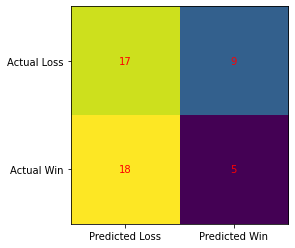

In [59]:
conf_m = confusion_matrix(y, predict)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(conf_m)
ax.grid(False)

ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Loss', 'Predicted Win'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Loss', 'Actual Win'))
ax.set_ylim(1.5, -0.5)

for b in range(2):
    for a in range(2):
        ax.text(a, b, conf_m[b, a], ha='center', va='center', color='red')
plt.show()

### Log curves

Text(0, 0.5, 'Election Outcome')

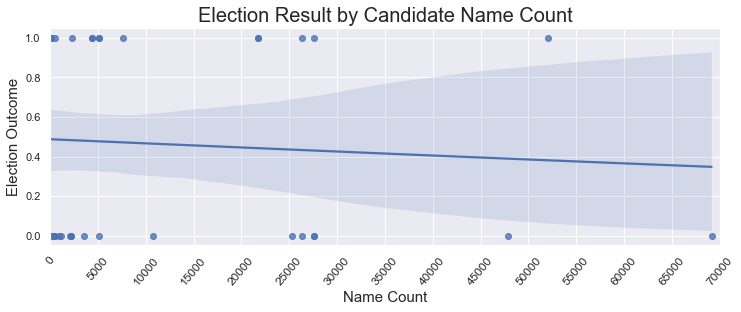

In [60]:
sns.set(rc={'figure.figsize':(12,4)})
ax = sns.regplot(x='Candidate Name Count',y='Election Outcome',data=data,logistic=True,ci=95)
xticks=(np.arange(0,75000,5000))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=50,size=12)
ax.set_title(label='Election Result by Candidate Name Count',size=20)
ax.set_xlabel(xlabel='Name Count',size=15)
ax.set_ylabel(ylabel='Election Outcome',size=15)

In [61]:
counts = (df[['Year','Election Outcome','Candidate First Name','Candidate Name Count']]).sort_values(by='Candidate Name Count',ascending=False)
counts[:3]

,Year,Election Outcome,Candidate First Name,Candidate Name Count
40,2004,0,John,69151.0
15,1960,1,John,52105.0
42,2008,0,John,47879.0


## Decision Tree

In [62]:
#drop categorical column 'Candidate First Name' since we have already frequency for this column
#drop the columns that are irrelevant and have no effect on the election outcome
df=df_all_freq.drop(['Candidate First Name','Candidate Spouse', 'First Child','Electoral Percentage','% of Popular Vote'], axis = 1)
df['Year'] = df.Year.astype(int)
df['Number of Spouses'] = df['Number of Spouses'].astype(int)
df.head()

,Year,Party,Candidate Birth Year,Number of Spouses,Spouse Birth Year,Number of Children,Child Birth Year,Election Outcome,Candidate Name Count,Candidate Name Frequency,Spouse Name Count,Spouse Name Frequency,Child Name Count,Child Name Frequency
0,1932,Democratic,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
1,1932,Republican,1880,1,1880,2.0,1903,0,424.0,0.002104,145.0,0.000720,668.0,0.001752
2,1936,Democratic,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
3,1936,Republican,1887,2,1887,3.0,1932,0,8.0,0.000032,29.0,0.000117,10990.0,0.005205
4,1940,Democratic,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547


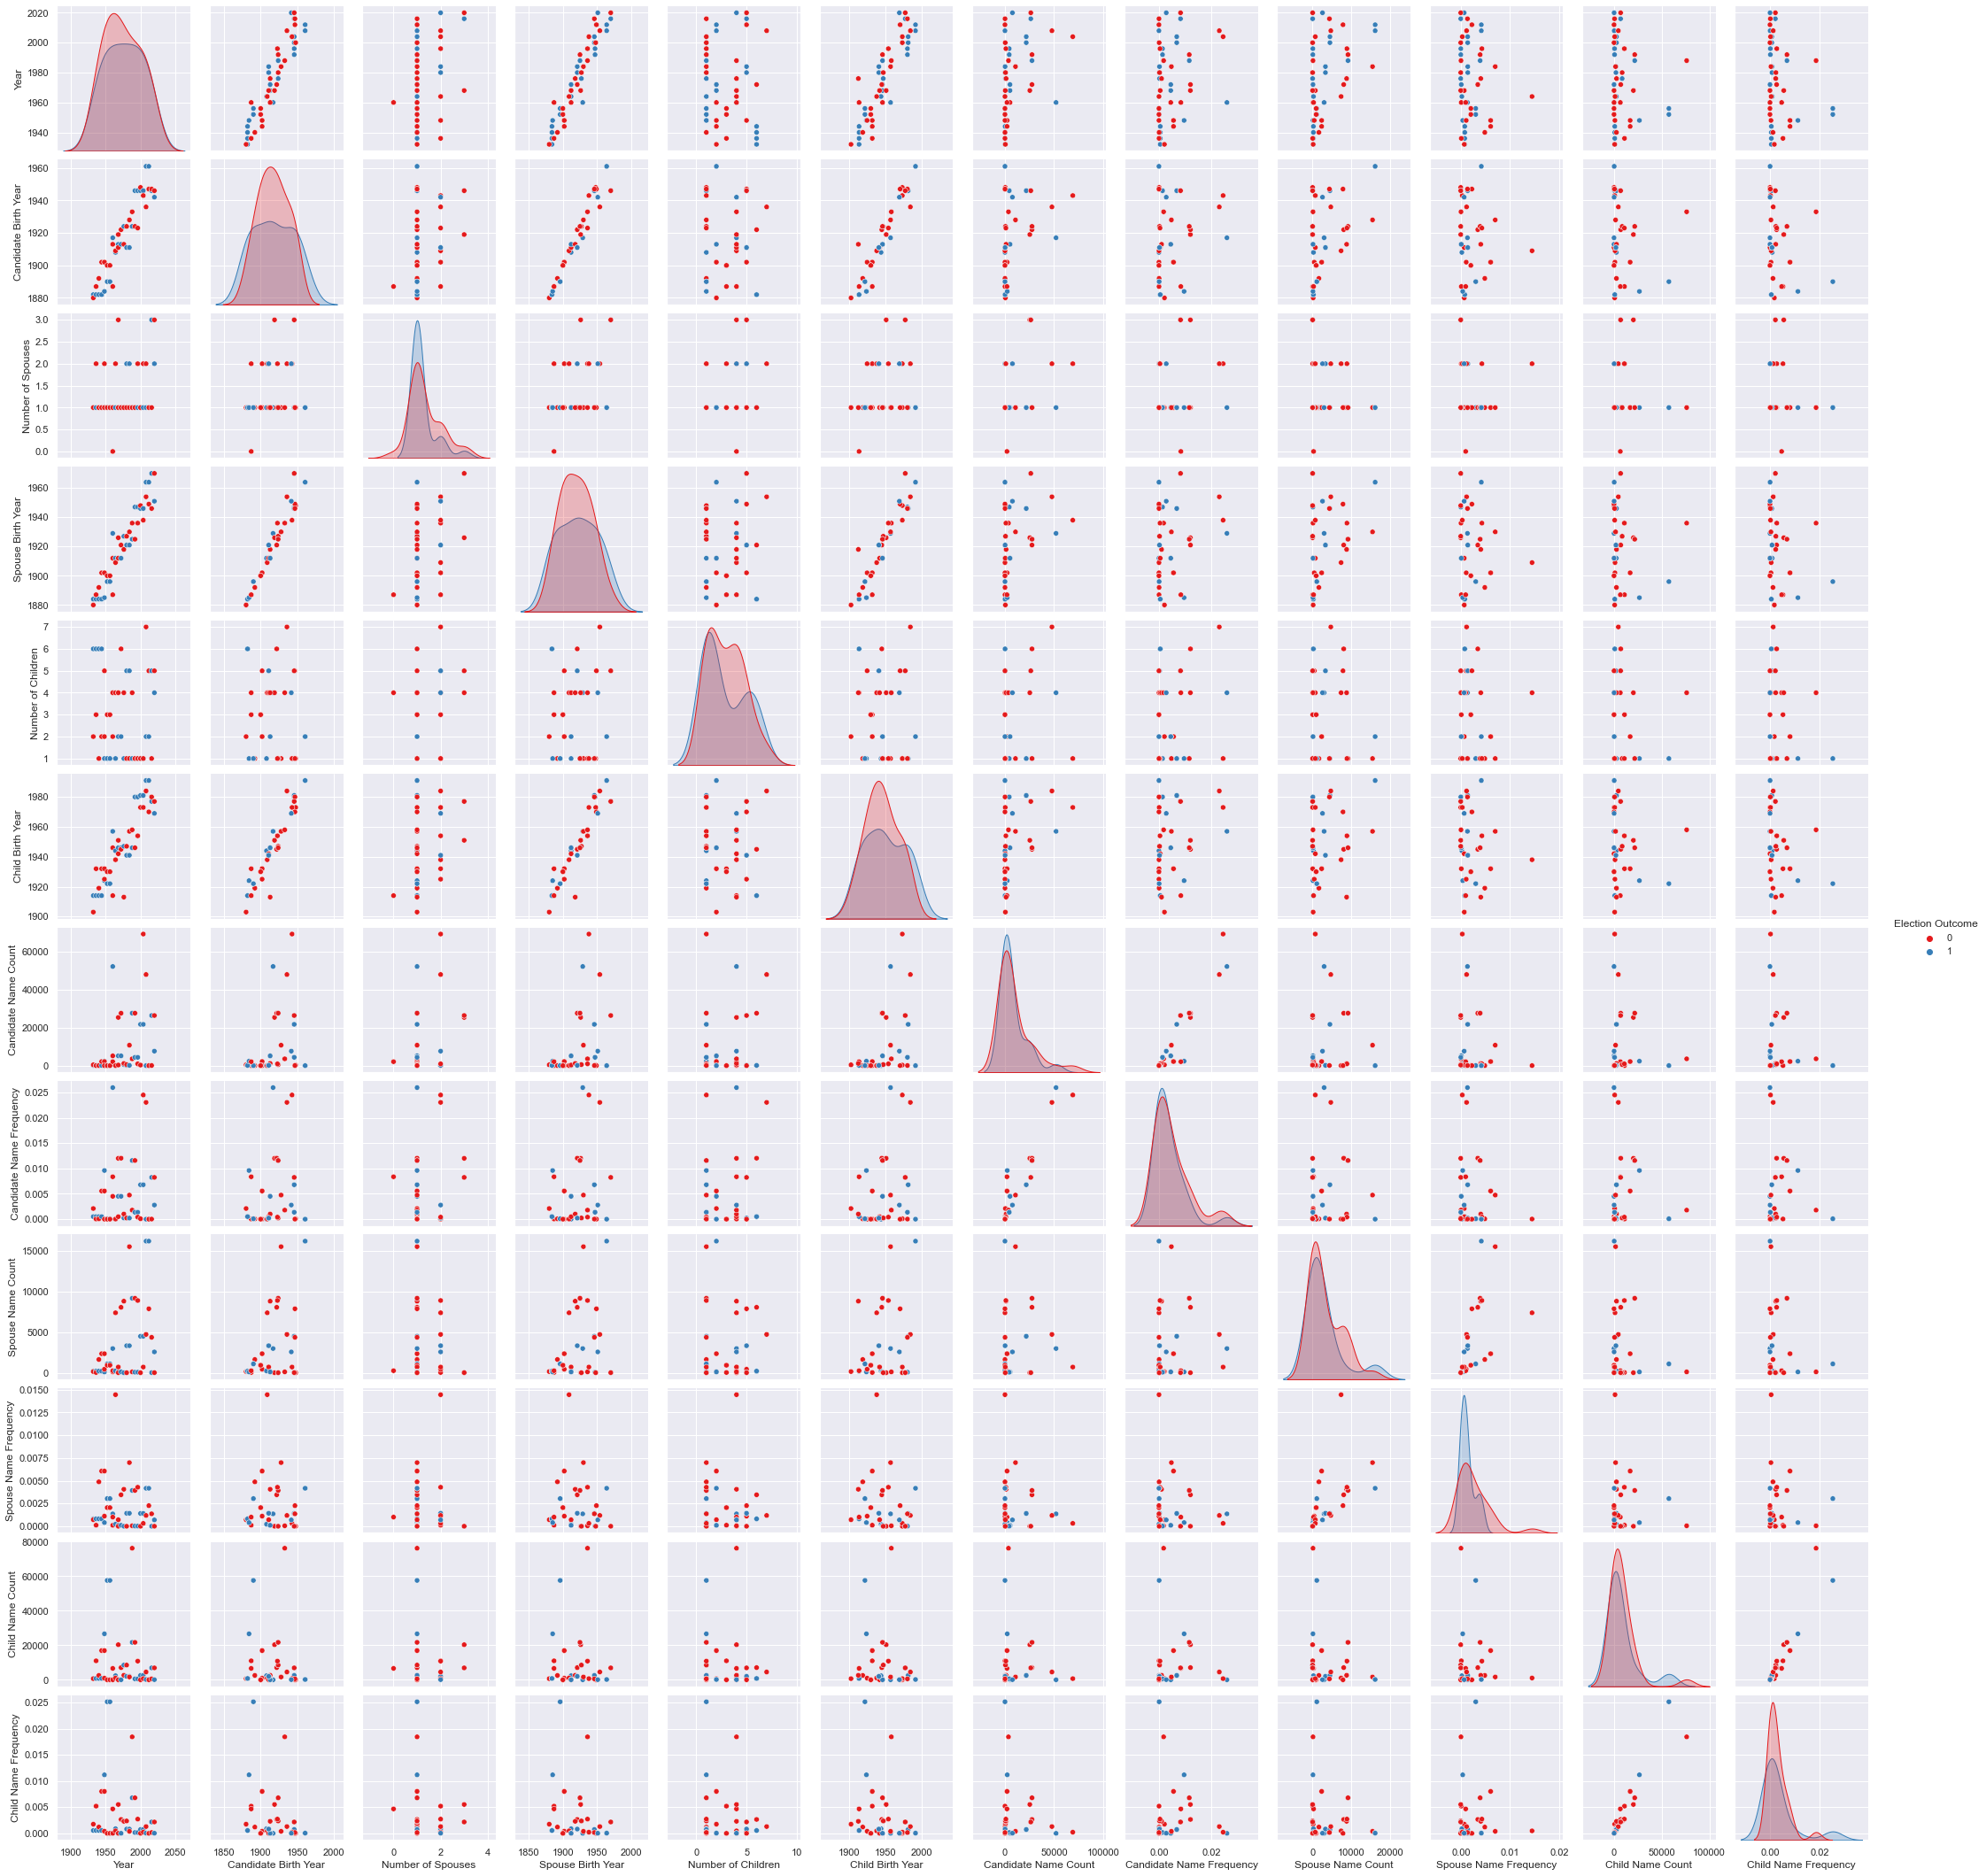

In [63]:
#plot pair plot to visualize the election outcome all at once
sns.pairplot(df,hue='Election Outcome',palette='Set1');

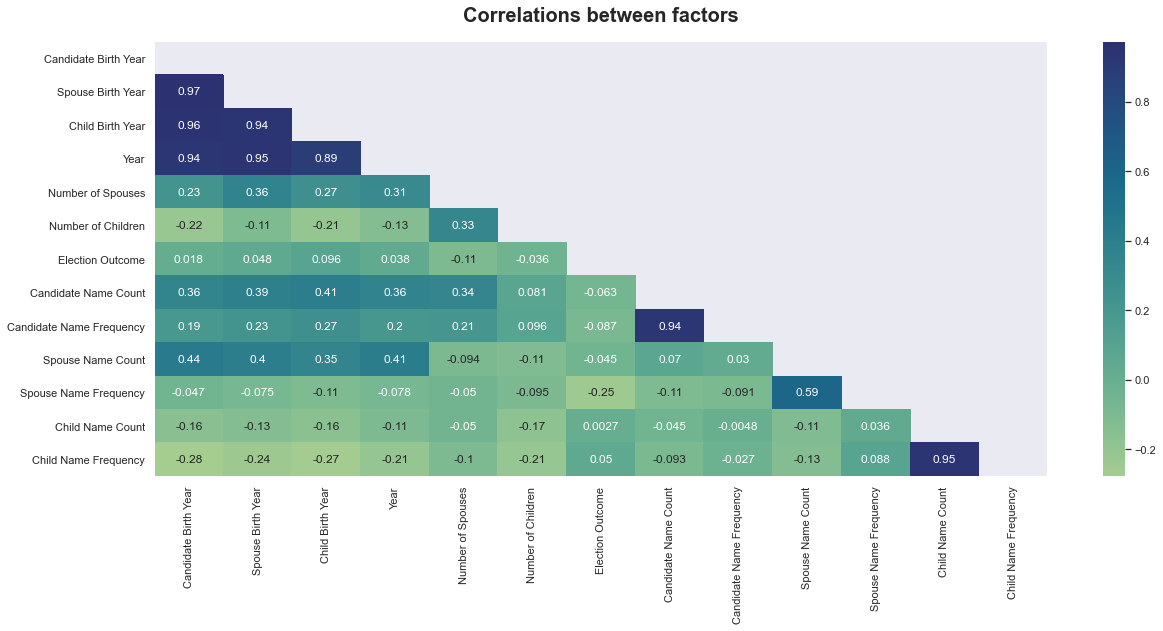

In [64]:
#correlation matrix
cols = df[['Candidate Birth Year','Spouse Birth Year','Child Birth Year','Year', 'Party', 'Number of Spouses',
       'Number of Children', 'Election Outcome','Candidate Name Count','Candidate Name Frequency',
                     'Spouse Name Count','Spouse Name Frequency','Child Name Count','Child Name Frequency']]
plt.figure(figsize=(20, 8))
sns.heatmap(cols.corr(), annot = True, cmap='crest', mask=np.triu(np.ones_like(cols.corr())));
plt.title('Correlations between factors', fontsize=20, fontweight='bold', pad=20);

We can observe from the above two plots:

The election outcome is not correlated to Candidate Name Frequency and Candidate Name Count.

In [65]:
#Convert to party names' as integer

#Democratic              1
#Republican              2
#Dixiecrat               3
#Southern Democratic     4
#American Independent    5

mymap1 = {'Democratic':1,'Republican':2,'Dixiecrat':3, 'Southern Democratic':4,'American Independent':3}
df = df.applymap(lambda s: mymap1.get(s) if s in mymap1 else s)
df.head()

,Year,Party,Candidate Birth Year,Number of Spouses,Spouse Birth Year,Number of Children,Child Birth Year,Election Outcome,Candidate Name Count,Candidate Name Frequency,Spouse Name Count,Spouse Name Frequency,Child Name Count,Child Name Frequency
0,1932,1,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
1,1932,2,1880,1,1880,2.0,1903,0,424.0,0.002104,145.0,0.000720,668.0,0.001752
2,1936,1,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547
3,1936,2,1887,2,1887,3.0,1932,0,8.0,0.000032,29.0,0.000117,10990.0,0.005205
4,1940,1,1882,1,1884,6.0,1914,1,112.0,0.000506,198.0,0.000813,775.0,0.000547


### Feature Selection

In [66]:
#split dataset in features and target variable
feature_cols = ['Year','Party', 'Candidate Birth Year', 'Number of Spouses', 'Spouse Birth Year','Number of Children','Child Birth Year','Candidate Name Count',
                'Candidate Name Frequency','Spouse Name Count','Spouse Name Frequency','Child Name Count','Child Name Frequency']
X = df[feature_cols] # Features
y = df['Election Outcome'] # Target variable
X.head()

,Year,Party,Candidate Birth Year,Number of Spouses,Spouse Birth Year,Number of Children,Child Birth Year,Candidate Name Count,Candidate Name Frequency,Spouse Name Count,Spouse Name Frequency,Child Name Count,Child Name Frequency
0,1932,1,1882,1,1884,6.0,1914,112.0,0.000506,198.0,0.000813,775.0,0.000547
1,1932,2,1880,1,1880,2.0,1903,424.0,0.002104,145.0,0.000720,668.0,0.001752
2,1936,1,1882,1,1884,6.0,1914,112.0,0.000506,198.0,0.000813,775.0,0.000547
3,1936,2,1887,2,1887,3.0,1932,8.0,0.000032,29.0,0.000117,10990.0,0.005205
4,1940,1,1882,1,1884,6.0,1914,112.0,0.000506,198.0,0.000813,775.0,0.000547


### Splitting Data

In [67]:
# do the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

Above line split the dataset for training and testing. As we are splitting the dataset in a ratio of 70:30 between training and testing so we are passing the test_size parameter’s value as 0.3

Random_state variable is a pseudo-random number generator state used for random sampling.

### Building Decision Tree Model

In [68]:
# create a decision tree model
dtree = DecisionTreeClassifier()
# train Decision Tree Classifer
dtree.fit(X_train,y_train)
# predict the response for test dataset
predictions = dtree.predict(X_test)

### Evaluating Model

In [69]:
# print the classification_report
print(classification_report(y_test,predictions))
# print the confusion matrix
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.50      0.67         8

    accuracy                           0.73        15
   macro avg       0.82      0.75      0.72        15
weighted avg       0.83      0.73      0.72        15

[[7 0]
 [4 4]]


Confusion Matrix is used to understand the trained classifier behavior over the test dataset or validate dataset.

In [70]:
# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score
print ("Accuracy : ",
    accuracy_score(y_test,predictions)*100)

Accuracy :  73.33333333333333


Well, we got a classification rate considered as good accuracy. We can improve this accuracy by tuning the parameters in the Decision Tree Algorithm.

In [71]:
#How to visualize a Decision Tree?
from sklearn import tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9), dpi=800)
#tree.plot_tree(dtree)

DecisionTreeClassifier()

Still, it is always better if we make our visualizations a bit more advanced

### Visualizing Decision Trees

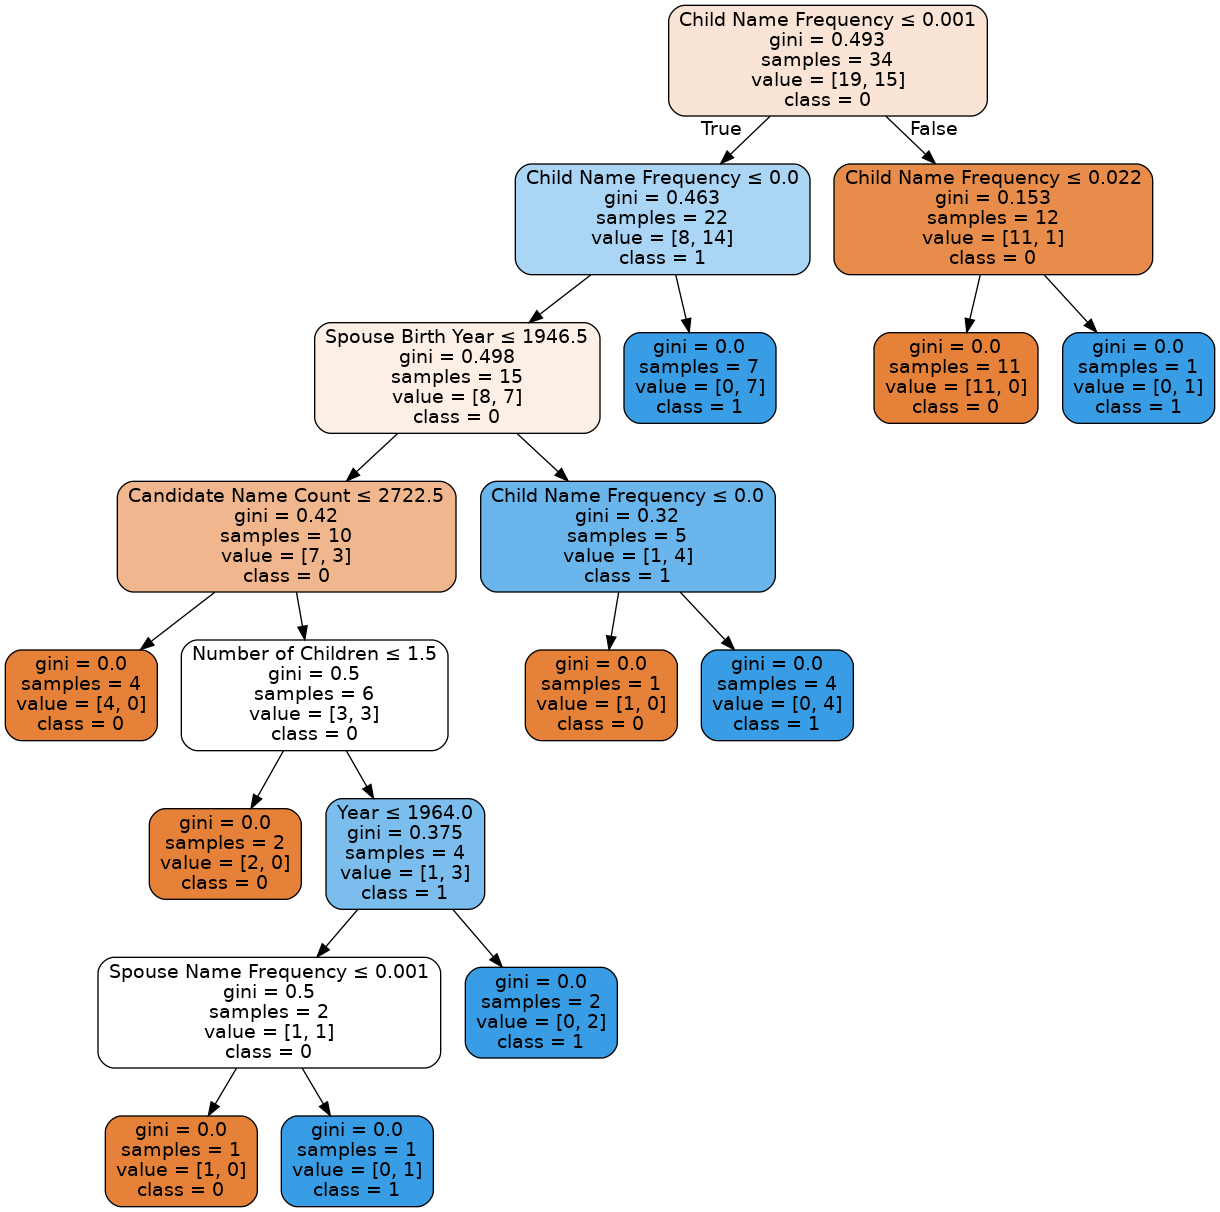

In [59]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('election.png')
Image(graph.create_png())

In the decision tree chart, each internal node has a decision rule that splits the data. Gini referred as Gini ratio, which measures the impurity of the node. We can say a node is pure when all of its records belong to the same class, such nodes known as the leaf node.

Here, the resultant tree is unpruned. This unpruned tree is unexplainable and not easy to understand. 

### Optimizing Decision Tree Performance

In [134]:
# Create Decision Tree classifer object
tree_clf  = DecisionTreeClassifier(criterion="entropy", max_depth=5)
# Train Decision Tree Classifer
tree_clf = tree_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = tree_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred)*100)

Accuracy: 73.33333333333333


In [135]:
# print the classification_report
print(classification_report(y_test,y_pred))
# print the confusion matrix
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.50      0.67         8

    accuracy                           0.73        15
   macro avg       0.82      0.75      0.72        15
weighted avg       0.83      0.73      0.72        15

[[7 0]
 [4 4]]


The classification rate increased to 73.33%, which is better accuracy than the previous model.

### Visualizing Decision Trees

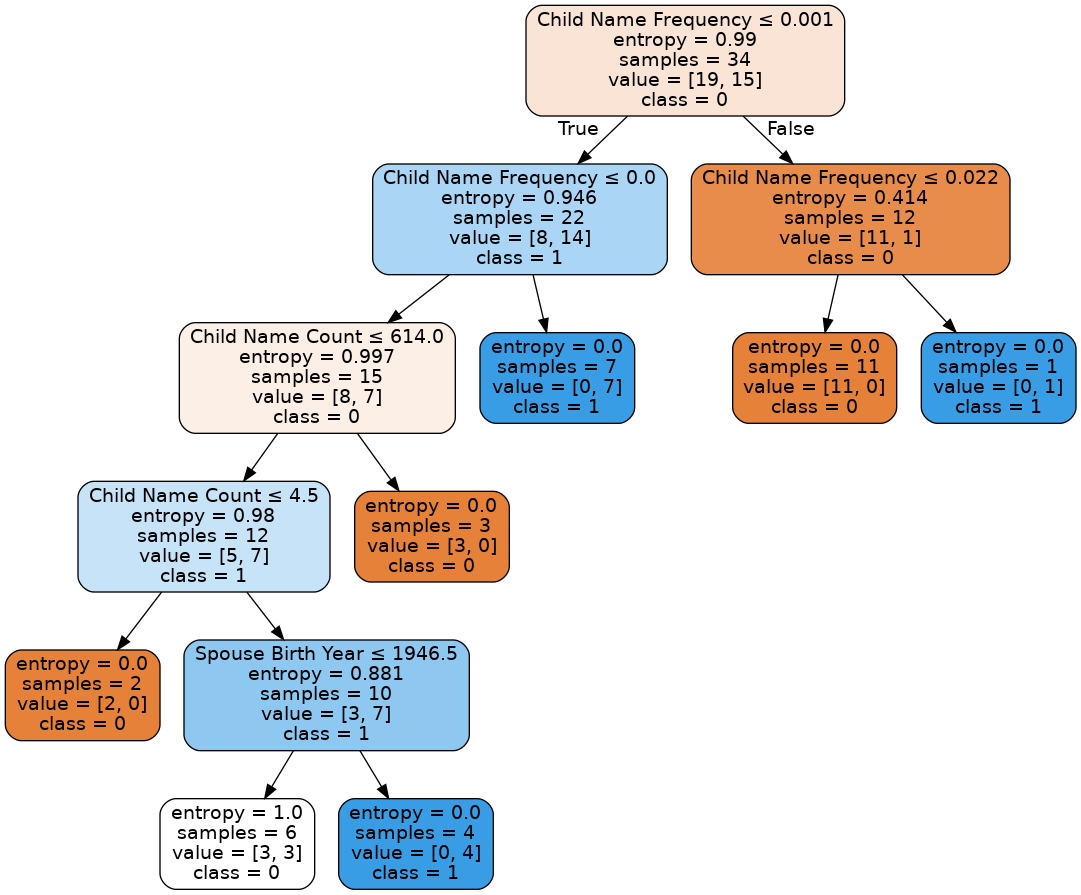

In [136]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('election.png')
Image(graph.create_png())

This pruned model is less complex, explainable, and easy to understand than the previous decision tree model plot.

## Random Forests

In [107]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [108]:
#Check the accuracy using actual and predicted values
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf)*100)

37.142857142857146


This gives 40% as the estimated accuracy of the trained Random Forest classifier

In [99]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.75      0.38      0.50         8

    accuracy                           0.60        15
   macro avg       0.65      0.62      0.58        15
weighted avg       0.65      0.60      0.58        15



In [100]:
print(confusion_matrix(y_test,y_pred_rf))

[[6 1]
 [5 3]]


### Finding Important Features

In [101]:
feature_importances = pd.DataFrame(rnd_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Child Name Frequency,0.143161
Child Name Count,0.111823
Candidate Name Frequency,0.099568
Year,0.096468
Candidate Birth Year,0.090283
Candidate Name Count,0.090003
Child Birth Year,0.083186
Spouse Name Frequency,0.079856
Spouse Name Count,0.076141
Spouse Birth Year,0.055571


Feature importance: the higher, the more important the feature

### Visualizing the feature importance

No handles with labels found to put in legend.


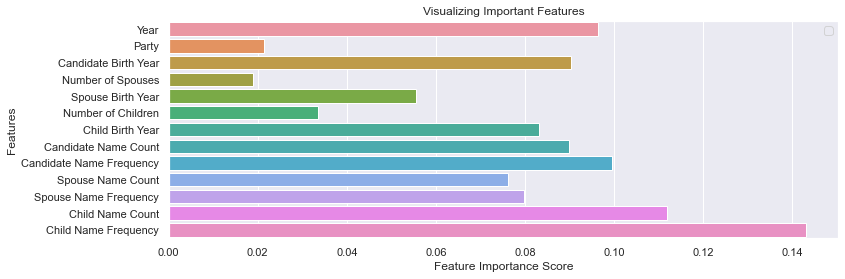

In [102]:
sns.barplot(x=rnd_clf.feature_importances_, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [103]:
# Split dataset into features and labels
X=df[['Spouse Name Frequency', 'Candidate Name Frequency','Candidate Name Count', 'Child Birth Year','Child Name Count',
        'Spouse Birth Year','Spouse Name Count','Child Name Frequency']]  # Removed the least important features
y=df['Election Outcome']                                       
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) # 70% training and 30% test

In [104]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4


We can see that after removing the least important features (Year,Candidate Birth Year), the accuracy increased. This is because we removed misleading data and noise, resulting in an increased accuracy. A lesser amount of features also reduces the training time.